In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Japanese', 'Dutch', 'Russian', 'Italian', 'German', 'Chinese', 'Polish', 'Korean', 'English', 'Czech', 'Irish', 'Greek', 'Portuguese', 'Arabic', 'Vietnamese', 'French', 'Scottish', 'Spanish']
O'Neal


In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        # This part here could be an extension of the previous architecture, or it
        # could be a module
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1) # Make an article explaining (and applying)
                                              # different activation functions
        
    def forward(self, category, X, hidden):
        input_combined = torch.cat((category, X, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output) # Study what is dropout
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

All the functions written here could be used in a Dataloader/Dataset.

In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end(EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) #EOS
    return torch.LongTensor(letter_indexes)

In [9]:
# Make category, input and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor



In [6]:
# In contrast to classification, where only the last output is used, we are making
# a prediction at every step, so we are calculating loss at every step

# The magic of autograd allows you to simply sum these losses at each step and 
# call backward at the end
# Study a little more how the autograd works

criterion = nn.NLLLoss()
# Write an article about each loss function, where it can be used and in what
# circunstances they are more adequate

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
        
    return output, loss.item() / input_line_tensor.size(0)

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 23s (5000 5%) 2.7863
0m 57s (10000 10%) 2.2888
1m 28s (15000 15%) 2.8250
1m 57s (20000 20%) 3.2503
2m 24s (25000 25%) 2.7343
2m 59s (30000 30%) 2.8611
3m 29s (35000 35%) 2.6046
3m 54s (40000 40%) 2.1239
4m 16s (45000 45%) 2.0113
4m 39s (50000 50%) 2.7278
5m 1s (55000 55%) 3.2079
5m 24s (60000 60%) 2.7100
5m 46s (65000 65%) 2.1599
6m 8s (70000 70%) 2.8469
6m 31s (75000 75%) 2.9624
6m 55s (80000 80%) 2.6115
7m 17s (85000 85%) 3.3247
7m 40s (90000 90%) 2.8449
8m 3s (95000 95%) 2.5216
8m 31s (100000 100%) 1.8291


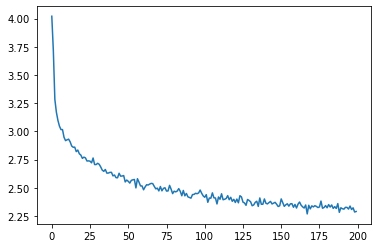

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses) # Edit the training functions of my other scripts to output
                     # all losses for plotting

In [14]:
# Sampling the Network
# Create tensors for input category, starting letter, and empty hidden state
# Create a string output_name with the starting letter
# Up to a maximum output length,
    # Feed the current letter to the network
    # Get the next letter from highest output, and next hidden state
    # If the letter is EOS, stop here
    # If a regular letter, add to output_name and continue
# Return the final name


max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter = 'A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        X = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, X[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            X = inputTensor(letter)
            
        return output_name
    
def samples(category, start_letters = 'ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')


Rovallov
Uanton
Sandinov
Garten
Eres
Rong
Santana
Parera
Aranera
Cha
Hango
Ia
